In [1]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2_contingency
from cellrank.estimators import GPCCA
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.collections as collections 
import scanpy.external as sce
import scrublet as scr
import cellrank as cr
import seaborn as sns
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import collections
import matplotlib
#import networkx
import anndata
#import network 
#import fsspec
#import igrap
import scvi
import desc
import umap
import sys
import h5py
import os
import re


#%load_ext rpy2.ipython
%matplotlib inline 


sc.settings.verbosity = 3     


# Setting the seed 
np.random.seed(42)


# Setting the figure parameters
sc.set_figure_params(figsize=(2.2, 2.2), format = 'svg', dpi_save = 300)

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [ ]:
# Reading in H5 file
adata = sc.read_10x_h5('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/OS052/filtered_feature_bc_matrix.h5')


# Making the var names unique
adata.var_names_make_unique()


# Annotating mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


# Thresholds for QC plots
variables = [
    ('n_genes_by_counts', [(1000, '--'), (10000, '--')]),
    ('pct_counts_mt', [(14, '--')]),
    ('total_counts', [(1300, '--'), (25000, '--')])
]


# Dictionary for new titles
titles = {
    'n_genes_by_counts': 'Gene Counts',
    'pct_counts_mt': 'Mito. Percentage',
    'total_counts': 'Total Counts'
}


# Setting the theme without gridlines
sns.set_theme(style="white")


# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))


# Iterate over the variables and their respective lines to plot
for ax, (var, lines) in zip(axes, variables):
    sns.kdeplot(data=adata.obs, x=var, fill=True, alpha=0.2, ax=ax,
                log_scale=True if var != 'pct_counts_mt' else False)
    for line, style in lines:
        ax.axvline(x=line, color='k', linestyle=style)
    ax.set_title(f"OS052 LT {titles[var]}")  # Simpler title without extra text
    ax.set_xlabel(titles[var])  # Optionally keep the x-label as the new title
    ax.set_ylabel("Cell density")


# Adjust layout to prevent overlap
plt.tight_layout()


# Save the figure as SVG
plt.savefig("/Users/brendamelano/Desktop/OS052_LT_filtering.svg")


# Show the plot
plt.show()



# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] <= 25000) &
              (adata.obs['total_counts'] >= 1300) &
                (adata.obs['n_genes_by_counts'] >= 1000) &
                (adata.obs['n_genes_by_counts'] < 10000) & #pct_counts_mt
                (adata.obs['pct_counts_mt'] < 14)
                ]


# Normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# Make sure that the log transformation is where it belongs in this preprocessing sequence
scv.pp.log1p(adata)


# Preserving the counts
adata.layers["counts"] = adata.X.copy() 


# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, # previously 1500
    subset=True,
    layer="counts"
)


#genes = adata.var.index.values


# reading in cell cycle genes in case I want to regress on that
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]


# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


# Keeping only the cell cycle genes within the adata object
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


# Computing the ccdifference scores
adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']


# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata

# Filtering the anndata object based on highly variable genes
adata = adata[:, adata.var.highly_variable]

# Regressing out counts, mitochondrial percentage and ccdifference scores
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)


# Computing principal components
sc.tl.pca(adata, svd_solver='arpack') #vary principal component number




computing neighbors
    using 'X_pca' with n_pcs = 10


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


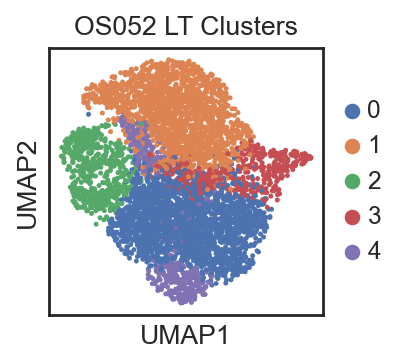

In [3]:
# Computing neighbors
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10)


# 
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.4)


sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS052 LT Clusters",
    size = 20,
    #save="OS052_LT_Clusters.svg"
)

In [35]:

# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/scRNAseq_LT_analysis/OS052/OS052_LT_adata_leiden_PCA.h5ad")


# Reading in state labeled data

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


AttributeError: module 'collections' has no attribute 'PathCollection'

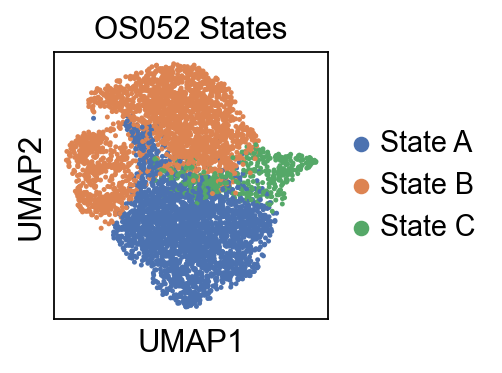

In [2]:
# Reading in the adata file from the subtype data
adata = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/scRNAseq_LT_analysis/OS052/OS052_adata_states_PCA.h5ad")


# Plot the UMAP
sc.pl.umap(
    adata,
    color=["State"],
    frameon=True,
    title="OS052 States",
    size=20,
    show=False  # Do not display the plot immediately
)


# Rasterize the scatter plot elements only
ax = plt.gca()
for artist in ax.get_children():
    if isinstance(artist, collections.PathCollection):  # Use the correct module path
        artist.set_rasterized(True)

        
# Save as an SVG with rasterized points
plt.savefig("/Users/brendamelano/Desktop/OS052_LT_clusters_rasterized.svg", format='svg')
plt.show()

# State module enrichment

computing score 'State_A_score'
    finished: added
    'State_A_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)
computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)


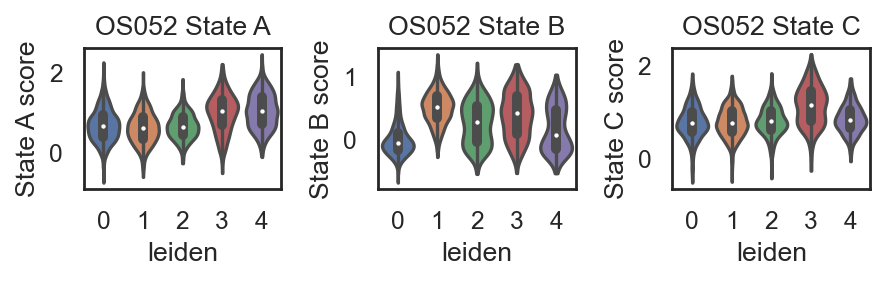

In [4]:
# Reading in gene lists for GSEA
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv')]
Subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv')]
Subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv')]


# Keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]
Subtype_B_genes = [x for x in Subtype_B_genes if x in adata.var_names]
Subtype_C_genes = [x for x in Subtype_C_genes if x in adata.var_names]


# Computing GSEA scores
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_A_score', random_state=0, copy=False, use_raw=None)

sc.tl.score_genes(adata, Subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)

sc.tl.score_genes(adata, Subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)


# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(5.7, 1.9))

sc.pl.violin(adata, ['State_A_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel='State A score', ax=axs[0], show=False)

axs[0].set_title('OS052 State A')

sc.pl.violin(adata, ['Subtype_B_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel='State B score', ax=axs[1], show=False)
axs[1].set_title('OS052 State B')

sc.pl.violin(adata, ['Subtype_C_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel='State C score', ax=axs[2], show=False)
axs[2].set_title('OS052 State C')

plt.tight_layout()


# Saving the figure onto the desktop
#plt.savefig('/Users/brendamelano/Desktop/OS152_gsea_scores.svg', format='svg')
plt.show()

In [6]:
# Extract the relevant columns from adata.obs
score_df = adata.obs[['leiden', 'State_A_score', 'Subtype_B_score', 'Subtype_C_score']].copy()

# Compute the median scores per cluster
median_scores = score_df.groupby('leiden')[['State_A_score', 'Subtype_B_score', 'Subtype_C_score']].mean()


# Here, a smaller rank means a higher score (rank=1 is the highest median score)
ranked_scores = median_scores.rank(method='dense', ascending=False, axis=0) 

# Assign each cluster the state with the highest median score
# idxmax on the median_scores DataFrame returns the column name (state) with the highest median for each cluster
cluster_state_assignment = ranked_scores.idxmin(axis=1)

# cluster_state_assignment is a Series indexed by cluster (leiden), with values as the top state per cluster
# Map this back onto each cell in the adata object
adata.obs['dominant_state'] = adata.obs['leiden'].map(cluster_state_assignment.to_dict())

# Optionally, inspect the results
print("Median Scores per Cluster:")
print(median_scores)

print("\nRanked Scores per Cluster (1 = highest median):")
print(ranked_scores)

print("\nDominant state assignment per Cluster:")
print(cluster_state_assignment)

# Now adata.obs['dominant_state'] contains the assigned dominant state for each cell based on its cluster.


Median Scores per Cluster:
        State_A_score  Subtype_B_score  Subtype_C_score
leiden                                                 
0            0.684182        -0.004620         0.783434
1            0.614356         0.503620         0.793126
2            0.656068         0.254484         0.813651
3            0.985177         0.384762         1.140814
4            1.042595         0.160974         0.855492

Ranked Scores per Cluster (1 = highest median):
        State_A_score  Subtype_B_score  Subtype_C_score
leiden                                                 
0                 3.0              5.0              5.0
1                 5.0              1.0              4.0
2                 4.0              3.0              3.0
3                 2.0              2.0              1.0
4                 1.0              4.0              2.0

Dominant state assignment per Cluster:
leiden
0      State_A_score
1    Subtype_B_score
2    Subtype_B_score
3    Subtype_C_score
4      St

In [6]:
ranked_scores

,State_A_score,Subtype_B_score,Subtype_C_score
leiden,,,
0,6.0,1.0,5.0
1,4.0,5.0,2.0
2,3.0,6.0,6.0
3,5.0,3.0,4.0
4,1.0,4.0,3.0
5,2.0,2.0,1.0


# State module markers by cluster

In [ ]:
# Read gene lists for each subtype from the CSV files
def read_genes(file_path):
    with open(file_path, 'r') as file:
        genes = [x.strip() for x in file]
    return genes


# Reading in the subtype gene modules
Subtype_A_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')
Subtype_B_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')
Subtype_C_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')


# Specified markers for visualization
specified_genes = ['UBE2C', 'AURKA', 'CENPF', 'AURKB', 'CKS2', 'TOP2A', 'CDK1', 'TUBB4B', 'ATAD2', 'H2AX']


# Ensure these genes are in the adata object
reduced_state_B_genes = [gene for gene in specified_genes if gene in adata.var_names]


plt.rcParams.update({'font.size': 12})


# Combine gene lists from all subtypes, ensuring uniqueness if necessary
combined_genes = list(set(Subtype_A_genes + reduced_state_B_genes + Subtype_C_genes))


# Keeping only genes that appear in the adata object
combined_genes = [gene for gene in combined_genes if gene in adata.var_names]


# Ensure the combined_genes are in your expression data
adata_subset = adata[:, adata.var_names.isin(combined_genes)]


# Create the state dictionary 
subtype_A_dict = {gene: 'A' for gene in Subtype_A_genes}
subtype_B_dict = {gene: 'B' for gene in reduced_state_B_genes}
subtype_C_dict = {gene: 'C' for gene in Subtype_C_genes}
subtype_dict = {**subtype_A_dict, **subtype_B_dict, **subtype_C_dict}


# Annotate the genes in adata with their subtype
adata.var['State'] = [subtype_dict.get(gene, 'Unknown') for gene in adata.var_names]


# Sort the genes in your subset by subtype
adata_subset = adata[:, adata.var_names.isin(combined_genes)]
adata_subset.var['subtype_order'] = adata_subset.var['State'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
adata_subset = adata_subset[:, adata_subset.var['subtype_order'].argsort()]


# Create a list of genes sorted by subtype for use in the matrixplot
sorted_genes_by_subtype = adata_subset.var_names.tolist()


# Create a figure explicitly
plt.figure(figsize=(2, 0.5), dpi=600) 


ax = sc.pl.matrixplot(
    adata_subset,
    var_names=sorted_genes_by_subtype,  # Use the sorted list of genes
    groupby='leiden',
    cmap="Reds",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS052 LT State Module Markers",
    show=False
)


# Save the figure using matplotlib's savefig with explicit format setting
#plt.savefig("/Users/brendamelano/Desktop/OS052_state_markers_by_cluster_LT.svg", format='svg')

plt.show()

plt.close()

# State Assignments

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


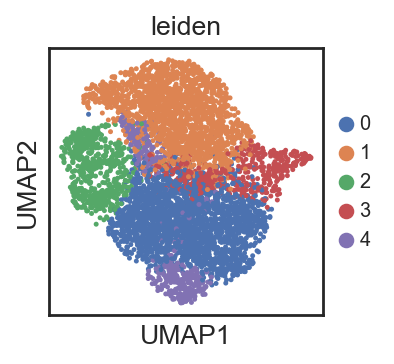

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html 

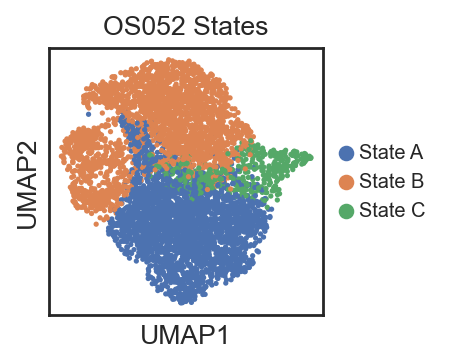

In [7]:
# Generating umap to visualize clusters
sc.pl.umap(adata, 
           color=['leiden'], 
           legend_fontsize=9, 
           size = 20)


adata.obs['leiden'] = adata.obs['leiden'].astype('category')


adata.obs['leiden'][adata.obs['leiden']=='0']='4'
adata.obs['leiden'][adata.obs['leiden']=='2']='1'



# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'State A': ['4'],  'State B': ['1'], 'State C':['3']}


# Initialize empty column in cell metadata
adata.obs['State'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'State'] = i

    
# Creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['State'].values)


# Define the number of clusters
n_subtypes = len(subtypes[0].unique())


# defining a pastel color palette
colors = sns.color_palette('pastel', n_subtypes)


sc.pl.umap(adata, color=['State'], 
           legend_fontsize=9, 
           title = "OS052 States") #, palette = subtype_colors


# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/scRNAseq_LT_analysis/OS052/OS052_adata_states_PCA.h5ad")


# GSEA

In [ ]:
# Define the directory for the gmt files
directory = '/Users/brendamelano/Desktop/gmt_files'


# Create a dictionary to store gene lists
gene_lists = {}


# Load gene lists from files
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

            
# Create a dictionary to store gene scores for each module
gene_scores = {}


# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue

        
# Define the score names
scores = [ 'GCNP_genes_score', 'CSR_genes_score',   
           'LEF1_genes_score', 'ESC_genes_score', 
          'TNFA_genes_score',
           'PDGF_ERK1_DOWN_genes_score', 'KRAS_genes_score', 'TGFB_genes_score',
           'IL2_genes_score', 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 
           'STK33_genes_score']


# Plotting the pathway matrix plot based on subtype
axes_dict = sc.pl.matrixplot(
    adata,
    scores,
    "leiden",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    show=False  # Prevents the plot from showing immediately
)


# Modify the x-axis and y-axis labels
for ax in axes_dict.values():
    # Update x-axis labels
    labels = [label.get_text().replace('_genes_score', '').replace('_', ' ') for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    
    # Set the y-axis labels to the cluster names
    cluster_labels = [f'Cluster {label.get_text()}' for label in ax.get_yticklabels()]
    ax.set_yticklabels(cluster_labels, fontsize=10)  # Adjust font size if needed

    # Add a title to the plot
    ax.set_title('OS052 LT Pathways', fontsize=12)

    
# Save the figure
plt.gcf().savefig('/Users/brendamelano/Desktop/OS052_Pathways_with_Clusters.svg', format='svg')  # Adjust path as needed


# Show the plot if desired
plt.show()

# Quantifying doublets

In [ ]:
scrub = scr.Scrublet(adata.raw.X)

out = scrub.scrub_doublets(verbose=False, n_prin_comps = 20)

adata_df = pd.DataFrame({'doublet_score':out[0],'predicted_doublets':out[1]},index = adata.obs.index)

adata_df

# printint the number of predicted doublets
print(adata_df.predicted_doublets.sum(), " predicted_doublets")


adata.obs['doublet_scores'] = adata_df['doublet_score'] 


adata.obs['predicted_doublets'] = adata_df['predicted_doublets'] 

sum(adata.obs['predicted_doublets'])

sc.pl.umap(adata, 
           color=['doublet_scores','doublet_info'])

# Enriched ATR barcode analysis

In [ ]:
# Defining the 10X cell barcodes
adata.obs['tenX_barcode'] = adata.obs.index #.str.extract(r':(.*?)x', expand=False)


# Saving the 10X cell barcodes in a column in adata.obs
tenX_barcodes = adata.obs['tenX_barcode']


# Reading in the depleted barcodes
depleted_cell_barcodes = pd.read_csv("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/OS052/", header=None)


# Isolating the barcode sequences alone (with no -1 suffix)
depleted_cell_barcodes = depleted_cell_barcodes[0]


depleted_10X = []


# Compile the pattern to match '-1' at the end of the string
pattern = re.compile(r"-1$")


for barcode in depleted_cell_barcodes:
    barcode_without_suffix = barcode
    if barcode_without_suffix in tenX_barcodes.str.replace(pattern, "").values:
        depleted_10X.append(barcode)
        

adata.obs['tenX_barcode'] = adata.obs['tenX_barcode'].str.replace(pattern, "")

        
adata.obs['depleted_10X'] = pd.Categorical(adata.obs['tenX_barcode'].isin(depleted_10X))


adata = adata[adata.obs['depleted_10X'].sort_values(ascending=False).index]


# Define a custom color palette where 'False' is gray and 'True' is the default color (e.g., orange)
custom_palette = ['#808080', 'orange']  # gray for 'False', orange for 'True'


# Reorder data so that 'True' values are plotted last (on top)
adata_temp = adata[adata.obs['depleted_10X'].sort_values().index]


# Plot the UMAP with the custom color palette and increased dot size
sc.pl.umap(adata_temp, color='depleted_10X', palette=custom_palette, 
           add_outline=True, s=30, title='OS052 depleted barcodes',
           save = "OS052_depleted_barcodes.svg")


In [ ]:
# Assuming 'adata' is your dataset
barcode_data = adata.obs


# Set a significance threshold
significance_threshold = 0.05


# Iterate over each cluster
for cluster in barcode_data['State'].unique():
    
    # Create a contingency table for the current cluster
    contingency_table = pd.DataFrame(
        [
            [
                ((barcode_data['depleted_10X'] == True) & (barcode_data['State'] == cluster)).sum(),
                ((barcode_data['depleted_10X'] == True) & (barcode_data['State'] != cluster)).sum(),
            ],
            [
                ((barcode_data['depleted_10X'] == False) & (barcode_data['State'] == cluster)).sum(),
                ((barcode_data['depleted_10X'] == False) & (barcode_data['State'] != cluster)).sum(),
            ],
        ],
        index=["Depleted_True", "Depleted_False"],
        columns=[f"In_Cluster_{cluster}", f"Outside_Cluster_{cluster}"]
    )

    # Adjust for zeros if necessary
    epsilon = 1e-10
    contingency_table += epsilon

    # Perform chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    is_significant = p < significance_threshold

    # Calculate proportions
    in_cluster_true = barcode_data[(barcode_data['State'] == cluster) & (barcode_data['depleted_10X'] == True)]
    in_cluster_all = barcode_data[barcode_data['State'] == cluster]

    outside_cluster_true = barcode_data[(barcode_data['State'] != cluster) & (barcode_data['depleted_10X'] == True)]
    outside_cluster_all = barcode_data[barcode_data['State'] != cluster]

    prop_in_cluster = len(in_cluster_true) / len(in_cluster_all)
    prop_outside_cluster = len(outside_cluster_true) / len(outside_cluster_all)


    categories = [f'In Cluster {cluster}', f'Outside Cluster {cluster}']
    proportions = [prop_in_cluster, prop_outside_cluster]

    # Create bar chart
    plt.figure(figsize=(5, 5))
    bars = plt.bar(categories, proportions, width=0.8, color=['#aec6cf', '#ffb6c1'])

    # Add a border and remove gridlines
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_color('black')
    plt.grid(False)

    # Add labels and title
    plt.ylabel('Proportion of Depleted barcodes', fontsize=14)
    plt.title(f'Cluster {cluster}: Proportion of Depleted Barcodes\n(p-value: {p:.2e}, Significant: {"Yes" if is_significant else "No"})', fontsize=14)

    # Add value labels on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2%}', va='bottom', fontsize=14)

    plt.tight_layout()
    plt.show()

In [3]:
def process_barcodes(adata, barcode_file_path, output_dir, cell_line, drug, significance_threshold=0.05):
    """
    Process enriched or depleted barcodes

    Parameters:
    - adata: AnnData object containing your single-cell data.
    - barcode_file_path: Path to the file containing enriched or depleted barcodes.
    - output_dir: Directory to save the plots.
    - cell_line: The name of the cell line (e.g., 'OS052', 'OS384', 'OS742').
    - drug: The name of the drug (e.g., 'ATR', 'PF', 'Cis').
    - significance_threshold: P-value threshold for statistical significance (default 0.05).
    """
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Determine the barcode type from the filename
    filename = os.path.basename(barcode_file_path).lower()
    if 'enriched' in filename:
        barcode_type = 'enriched'
    elif 'depleted' in filename:
        barcode_type = 'depleted'
    else:
        raise ValueError('Could not determine barcode type (enriched or depleted) from filename.')
    
    print(f"Processing {barcode_type} barcodes from file: {barcode_file_path}")
    
    # Defining the 10X cell barcodes
    adata.obs['tenX_barcode'] = adata.obs.index
    
    # Remove '-1' suffix from 'tenX_barcode'
    adata.obs['tenX_barcode'] = adata.obs['tenX_barcode'].str.replace('-1$', '', regex=True)
    
    # Reading in enriched or depleted 10X cell barcodes
    cell_barcodes = pd.read_csv(barcode_file_path, header=None)[0]
    
    # Remove '-1' suffix from cell barcodes
    #cell_barcodes = cell_barcodes.str.replace('-1$', '', regex=True)
    
    # Add a new column to adata.obs indicating whether each barcode is in the list
    column_name = f"{barcode_type}_10X"
    adata.obs[column_name] = pd.Categorical(adata.obs['tenX_barcode'].isin(cell_barcodes))
    
    # Sort the data (optional)
    adata_temp = adata[adata.obs[column_name].sort_values().index]
    
    # Define custom color palette
    if barcode_type == 'enriched':
        custom_palette = ['#808080', 'orange']  # gray for 'False', orange for 'True'
    elif barcode_type == 'depleted':
        custom_palette = ['#808080', 'blue']  # gray for 'False', blue for 'True']
    
    # Plot the UMAP with the custom color palette
    sc.pl.umap(adata_temp, color=column_name, palette=custom_palette, 
               add_outline=True, size=30, title=f"{cell_line} {barcode_type.capitalize()} Barcodes", show=False)
    
    # Save the UMAP plot
    umap_filename = os.path.join(output_dir, f"{cell_line}_{barcode_type}_barcodes.svg")
    plt.savefig(umap_filename, format='svg')
    plt.close()
    print(f"UMAP plot saved to {umap_filename}")
    
    # Setting the observational data as a DataFrame
    barcode_data = adata.obs.copy()
    
    # Map 'PF' to 'CDK-4/6' for labeling
    drug_label = 'CDK-4/6' if drug == 'PF' else drug
    
    # Iterate over each cluster
    for cluster in barcode_data['State'].unique():
        
        # Create a contingency table for the current cluster
        contingency_table = pd.DataFrame(
            [
                [
                    ((barcode_data[column_name] == True) & (barcode_data['State'] == cluster)).sum(),
                    ((barcode_data[column_name] == True) & (barcode_data['State'] != cluster)).sum(),
                ],
                [
                    ((barcode_data[column_name] == False) & (barcode_data['State'] == cluster)).sum(),
                    ((barcode_data[column_name] == False) & (barcode_data['State'] != cluster)).sum(),
                ],
            ],
            index=[f"{barcode_type.capitalize()}_True", f"{barcode_type.capitalize()}_False"],
            columns=[f"In_Cluster_{cluster}", f"Outside_Cluster_{cluster}"]
        )
    
        # Adjust for zeros if necessary
        if (contingency_table == 0).any().any():
            epsilon = 1e-10
            contingency_table += epsilon
    
        # Perform chi-squared test
        chi2, p, _, _ = chi2_contingency(contingency_table)
        is_significant = p < significance_threshold
    
        # Calculate proportions
        in_cluster_true = barcode_data[(barcode_data['State'] == cluster) & (barcode_data[column_name] == True)]
        in_cluster_all = barcode_data[barcode_data['State'] == cluster]
    
        outside_cluster_true = barcode_data[(barcode_data['State'] != cluster) & (barcode_data[column_name] == True)]
        outside_cluster_all = barcode_data[barcode_data['State'] != cluster]
    
        prop_in_cluster = len(in_cluster_true) / len(in_cluster_all) if len(in_cluster_all) > 0 else 0
        prop_outside_cluster = len(outside_cluster_true) / len(outside_cluster_all) if len(outside_cluster_all) > 0 else 0
    
        # Data for plotting
        categories = [f'In {cluster}', f'Outside {cluster}']
        proportions = [prop_in_cluster, prop_outside_cluster]
    
        # Create bar chart
        plt.figure(figsize=(2.7, 2.3))
        bars = plt.bar(categories, proportions, width=0.8, color=['#aec6cf', '#ffb6c1'])
        plt.xticks(fontsize=9)
        
        # Customize y-axis: setting tick positions and font size
        max_prop = max(proportions)
        tick_values = np.linspace(0, max_prop, num=5)  # Creates 5 evenly spaced ticks from 0 to max_prop
        plt.yticks(tick_values, [f'{x:.2f}' for x in tick_values], fontsize=8)  # Format tick labels to two decimal places
    
        # Add a border and remove gridlines
        for spine in plt.gca().spines.values():
            spine.set_visible(True)
            spine.set_color('black')
        plt.grid(False)
    
        # Add labels and title
        plt.ylabel(f"{drug_label} {barcode_type.capitalize()} Barcodes", fontsize=9)
        plt.title(f"{cell_line} Proportion of {barcode_type.capitalize()} Barcodes", fontsize=9)
    
        # Add p-value within the plot
        plt.text(1, max(proportions), f'p={p:.2e}', ha='right', va='bottom', fontsize=9, color='black')
    
        # Add value labels on each bar
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2%}', va='bottom', fontsize=9)
    
        plt.tight_layout()
    
        # Construct the filename
        significance_label = 'significant' if is_significant else 'not_significant'
        filename = f'{cell_line}_{drug}_{barcode_type}_Cluster_{cluster}_p-value_{p:.2e}_{significance_label}.svg'
        file_path = os.path.join(output_dir, filename)
    
        # Save the plot
        plt.savefig(file_path, format='svg')
        plt.close()  # Close the plot to free memory
        print(f"Saved plot for cluster {cluster}: {file_path}")

In [9]:
# Path to the barcode file (replace with your actual file path)
barcode_file_path = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/scRNAseq_LT_analysis/OS052/OS052_LT_ATR_depleted_10X_cell_barcodes.txt"


# Output directory where plots will be saved
output_dir = '/Users/brendamelano/Desktop'


# Cell line and drug information
cell_line = 'OS052'
drug = 'ATR'


# Call the function
process_barcodes(adata, barcode_file_path, output_dir, cell_line, drug)

Processing depleted barcodes from file: /Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/scRNAseq_LT_analysis/OS052/OS052_LT_ATR_depleted_10X_cell_barcodes.txt


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'c

UMAP plot saved to /Users/brendamelano/Desktop/OS052_depleted_barcodes.svg
Saved plot for cluster State A: /Users/brendamelano/Desktop/OS052_ATR_depleted_Cluster_State A_p-value_1.00e+00_not_significant.svg
Saved plot for cluster State B: /Users/brendamelano/Desktop/OS052_ATR_depleted_Cluster_State B_p-value_4.51e-03_significant.svg


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

Saved plot for cluster State C: /Users/brendamelano/Desktop/OS052_ATR_depleted_Cluster_State C_p-value_6.17e-07_significant.svg


In [4]:
# Path to the barcode file (replace with your actual file path)
barcode_file_path = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/scRNAseq_LT_analysis/OS052/OS052_LT_PF_depleted_10X_cell_barcodes.txt"


# Output directory where plots will be saved
output_dir = '/Users/brendamelano/Desktop'


# Cell line and drug information
cell_line = 'OS052'
drug = 'PF'


# Call the function
process_barcodes(adata, barcode_file_path, output_dir, cell_line, drug)

Processing depleted barcodes from file: /Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/scRNAseq_LT_analysis/OS052/OS052_LT_PF_depleted_10X_cell_barcodes.txt


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


UMAP plot saved to /Users/brendamelano/Desktop/OS052_depleted_barcodes.svg
Saved plot for cluster State A: /Users/brendamelano/Desktop/OS052_PF_depleted_Cluster_State A_p-value_7.94e-01_not_significant.svg
Saved plot for cluster State B: /Users/brendamelano/Desktop/OS052_PF_depleted_Cluster_State B_p-value_9.18e-03_significant.svg
Saved plot for cluster State C: /Users/brendamelano/Desktop/OS052_PF_depleted_Cluster_State C_p-value_2.76e-07_significant.svg


In [10]:
# Adding a new column "cell_line" with the value "OS052" for each row
adata.obs["cell_line"] = "OS052"
adata.obs


# Selecting only the columns 'depleted_10X', 'State', and 'cell_line' for the new DataFrame
OS052_modeling_df = adata.obs[["depleted_10X", "State", "cell_line"]]
OS052_modeling_df


# Saving new DataFrame to a CSV file
OS052_modeling_df.to_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/scRNAseq_LT_analysis/OS052/OS052_ATR_modeling_df.csv', index=False)


df = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/scRNAseq_LT_analysis/OS052/OS052_ATR_modeling_df.csv')
df

,depleted_10X,State,cell_line
0,True,State A,OS052
1,False,State B,OS052
2,False,State B,OS052
3,True,State C,OS052
4,False,State B,OS052
...,...,...,...
5360,True,State B,OS052
5361,False,State B,OS052
5362,False,State A,OS052
5363,True,State A,OS052


In [5]:
# Adding a new column "cell_line" with the value "OS052" for each row
adata.obs["cell_line"] = "OS052"
adata.obs


# Selecting only the columns 'depleted_10X', 'State', and 'cell_line' for the new DataFrame
OS052_modeling_df = adata.obs[["depleted_10X", "State", "cell_line"]]
OS052_modeling_df


# Saving new DataFrame to a CSV file
OS052_modeling_df.to_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/scRNAseq_LT_analysis/OS052/OS052_PF_modeling_df.csv', index=False)


df = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Lineage_Tracing/scRNAseq_LT_analysis/OS052/OS052_PF_modeling_df.csv')
df

,depleted_10X,State,cell_line
0,False,State A,OS052
1,False,State B,OS052
2,False,State B,OS052
3,False,State C,OS052
4,False,State B,OS052
...,...,...,...
5360,False,State B,OS052
5361,False,State B,OS052
5362,False,State A,OS052
5363,False,State A,OS052


# Trajectory barcode analysis

In [ ]:
# reading in depleted 10X cell barcodes
trajectory_cell_barcodes = pd.read_csv("/Users/brendamelano/Desktop/trajectory_10X_384_inVivo_LT.csv")


# creating a vector with just the barcodes
trajectory_cell_barcodes = trajectory_cell_barcodes['x']


# removing the suffix from the seurat barcodes
trajectory_cell_barcodes = trajectory_cell_barcodes.map(lambda x: x.lstrip('').rstrip('-1'))

adata_obs = adata.obs_names

adata_obs = adata_obs.to_numpy()

# create new categorical column called `selection`
adata.obs['trajectory_10X'] = pd.Categorical(adata.obs_names.isin(trajectory_cell_barcodes)) 

sc.pl.umap(adata, color='trajectory_10X', add_outline=True, s=90, size = 20, title = 'Trajectory in OS384')

# reading in depleted 10X cell barcodes
trajectory_cell_barcodes = pd.read_csv("/Users/brendamelano/Desktop/trajectory_10X_384_inVivo_LT.csv")

# creating a vector with just the barcodes
trajectory_cell_barcodes = trajectory_cell_barcodes['x']

# removing the suffix from the seurat barcodes
trajectory_cell_barcodes = trajectory_cell_barcodes.map(lambda x: x.lstrip('').rstrip('-1'))

adata_obs = adata.obs_names

adata_obs = adata_obs.to_numpy()

# create new categorical column called `selection`
adata.obs['trajectory_10X'] = pd.Categorical(adata.obs_names.isin(trajectory_cell_barcodes)) 

sc.pl.umap(adata, color='trajectory_10X', add_outline=True, s=90, size = 20, title = 'Trajectory in OS384')

In [ ]:
colors = ["yellow", "purple"]  # You can also use RGB tuples
cmap_name = "yellow_purple"

yellow_purple_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

plt.register_cmap(cmap=yellow_purple_cmap)


In [ ]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import kruskal

def plot_facet_gene_expression(adata, gene_list, output_file, cell_line, significance_threshold=0.05):
    """
    Quantify and visualize the expression of specified genes as a facet plot across different states.
    Applies FDR correction for multiple testing.

    Parameters:
    - adata: AnnData object 
    - gene_list: List of gene names to quantify and plot.
    - output_file: Path to save the resulting facet plot.
    - cell_line: String specifying the cell line name to include in plot titles.
    - significance_threshold: FDR threshold for significance (default is 0.05).
    """
    # Filter genes to keep only those present in the dataset
    genes_in_data = [gene for gene in gene_list if gene in adata.var_names]
    genes_not_found = [gene for gene in gene_list if gene not in adata.var_names]

    if genes_not_found:
        print(f"The following genes were not found in the dataset and will be skipped: {', '.join(genes_not_found)}")
    
    if not genes_in_data:
        print("None of the specified genes are present in the dataset.")
        return

    # List to store p-values for correction
    p_values = []

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame()

    # Calculate mean expression and perform tests for each gene
    for gene in genes_in_data:
        
        # Extract the gene expression data
        gene_data = adata[:, gene].X.toarray().flatten()  # Get the gene expression vector

        # Create a DataFrame with state, gene name, and expression data
        gene_df = pd.DataFrame({
            'State': adata.obs['State'],
            'Expression': gene_data,
            'Gene': gene
        })

        # Append the gene-specific data to the main plot_df
        plot_df = pd.concat([plot_df, gene_df], axis=0)

        # Perform Kruskal-Wallis test (non-parametric alternative to ANOVA)
        _, p_value = kruskal(*[gene_df.loc[gene_df['State'] == state, 'Expression'] for state in gene_df['State'].unique()])
        p_values.append(p_value)

    # Apply Benjamini-Hochberg (BH) correction
    _, corrected_pvals, _, _ = multipletests(p_values, alpha=significance_threshold, method='fdr_bh')

    # Add corrected p-values to the DataFrame
    pval_dict = dict(zip(genes_in_data, corrected_pvals))
    plot_df['Corrected p-value'] = plot_df['Gene'].map(pval_dict)

    # Create the facet plot
    g = sns.FacetGrid(plot_df, col='Gene', col_wrap=2, sharey=False, height=3, aspect=1.3)
    g.map(sns.barplot, 'State', 'Expression', palette='Set2', edgecolor='black')

    # Customize plot appearance
    for ax, gene in zip(g.axes.flat, genes_in_data):
        
        # Annotate each plot with the corrected p-value only
        pval = pval_dict[gene]
        ax.text(0.95, 0.95, f'p = {pval:.2e}',
                horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, fontsize=12)  # Adjust p-value font size
        
        # Customize tick and label fonts
        ax.set_xlabel('')
        ax.set_ylabel(f'{gene} Expression', fontsize=12)  # Adjust Y-axis label font size
        ax.tick_params(axis='x', labelsize=12)  # Adjust X-axis number font size
        ax.tick_params(axis='y', labelsize=12)  # Adjust Y-axis number font size
        ax.set_title(f"{cell_line} - {gene}", fontsize=14)  # Adjust title font size

    # Set overall plot labels and layout
    g.set_titles(col_template="{col_name}", fontsize=14)  # Adjust the facet title font size
    g.set_xlabels("State", fontsize=14)  # Adjust X-axis label font size
    g.set_ylabels("Expression", fontsize=14)  # Adjust Y-axis label font size
    g.fig.suptitle(f"{cell_line} Gene Expression Across States", y=1.05, fontsize=20)  # Adjust the master title font size
    g.fig.tight_layout()

    # Save the facet plot
    plt.savefig(output_file, format='svg', dpi=300)
    plt.close()
    print(f"Facet plot saved to {output_file}")


# Path to save the output plot
output_file = '/Users/brendamelano/Desktop/OS052_drivers_expression_facet.svg'


# Specify the cell line name
cell_line = 'OS052'


# Gene list
gene_list = ['DDIT3', 'TSHZ2', 'STAT1', 'NR0B1', 'NFE2L3', 'TCF4', 'NFKB2', 'IRF1', 'ZIC2', 'KLF12', 'JUNB', 'JUN']


# Call the function to generate the facet plot
plot_facet_gene_expression(adata, gene_list, output_file, cell_line)

In [ ]:
# Reading in gene lists for GSEA
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')]
Subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')]
Subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')]


# Keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]
Subtype_B_genes = [x for x in Subtype_B_genes if x in adata.var_names]
Subtype_C_genes = [x for x in Subtype_C_genes if x in adata.var_names]


# Computing GSEA scores
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_A_score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, Subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, Subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)


# Plotting the results with all fonts set to 9 and slanted x-axis titles
fig, axs = plt.subplots(1, 3, figsize=(6, 2.1))

sc.pl.violin(adata, ['State_A_score'], 
             groupby='State', stripplot=False, inner='box', 
             ylabel='', ax=axs[0], show=False)  # Set ylabel to empty string

axs[0].set_title('OS052 State A', fontsize=9)
axs[0].set_ylabel('State A score', fontsize=9)  # Set y-axis label with fontsize 9
axs[0].tick_params(axis='both', which='major', labelsize=9)
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_xlabel('')  # Remove x-axis label

sc.pl.violin(adata, ['Subtype_B_score'], 
             groupby='State', stripplot=False, inner='box', 
             ylabel='', ax=axs[1], show=False)  # Set ylabel to empty string

axs[1].set_title('OS052 State B', fontsize=9)
axs[1].set_ylabel('State B score', fontsize=9)  # Set y-axis label with fontsize 9
axs[1].tick_params(axis='both', which='major', labelsize=9)
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_xlabel('')  # Remove x-axis label

sc.pl.violin(adata, ['Subtype_C_score'], 
             groupby='State', stripplot=False, inner='box', 
             ylabel='', ax=axs[2], show=False)  # Set ylabel to empty string

axs[2].set_title('OS052 State C', fontsize=9)
axs[2].set_ylabel('State C score', fontsize=9)  # Set y-axis label with fontsize 9
axs[2].tick_params(axis='both', which='major', labelsize=9)
axs[2].tick_params(axis='x', rotation=45)
axs[2].set_xlabel('')  # Remove x-axis label

plt.tight_layout()

# Saving the figure onto the desktop
plt.savefig('/Users/brendamelano/Desktop/OS052_gsea_scores.svg', format='svg')
plt.show()


# scoring cell cycle

In [ ]:
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]


# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

sc.pl.umap(
    adata,
    color=["phase"],
    frameon=True,
    title = "OS384 Cell Cycle classification"
)

# pathway enrichment analysis

In [ ]:
# Defining the directory for the gmt files
directory = '/Users/brendamelano/Desktop/gmt_files'


# Create a dictionary to store gene lists
gene_lists = {}


# Create variables for gene lists
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

# Create a dictionary to store gene scores for each module
gene_scores = {}

# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue

        
scores = ['CSR_genes_score', 'GCNP_genes_score','LEF1_genes_score',
          'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 'TGFB_genes_score',   'STK33_genes_score',
          'PDGF_ERK1_DOWN_genes_score','IL2_genes_score',
         'ESC_genes_score',  'TNFA_genes_score', 'KRAS_genes_score']


sc.pl.matrixplot(
    adata,
    scores,
    "leiden",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)


In [ ]:
# Extract only the variable names before the first underscore
gene_variables = [score.split('_')[0] for score in scores]

# Create a new figure and axis for the heatmap
fig, ax = plt.subplots(figsize=(8, 12))

# Plot the heatmap using seaborn
sns.heatmap(
    adata.obs,
    xticklabels=gene_variables,
    yticklabels=False,  # Optionally, you can set yticklabels to False if you don't want them
    cmap='viridis',
    annot=False,  # Optionally, set annot=True to display numerical values
    cbar=True,
    linewidths=0.5,  # Optionally, set linewidths to adjust cell spacing
    ax=ax,
)

# Set the title of the heatmap (you can customize this)
plt.title("Heatmap of Gene Scores")

# Save the heatmap with a DPI of 300 as an SVG file
plt.savefig("OS384_pathway_heatmap.svg", dpi=300, bbox_inches='tight')

# Show the heatmap (optional, you can remove this line if you don't want to display it)
plt.show()

# DGE between all clusters

In [ ]:
# comparing each cell type to the rest
de_df = model.differential_expression(
    groupby="leiden_scVI",
)

de_df.head()

# identifying the top marklers within each cluster

# creating an empty array with which to store the markers
markers = {}


cats = adata.obs.leiden_scVI.cat.categories


for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 1]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:30]
    

sc.pl.heatmap(
    adata,
    markers,
    groupby="leiden_scVI",
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12),
)

# DGEA between 2 cell types

In [ ]:
# performing dgea between two cell types
# This command may be outdated
de_df = model.differential_expression(
    group1="3",
    group2="1",
    groupby="leiden_scVI"
)

de_df.head(20)

# heatmap
sc.pl.heatmap(
    adata, 
    markers, 
    groupby='cell_type', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

de_df[de_df.group1 == '3']

In [ ]:
markers = {'Source': ['MGLL',
  'TUBA4A',
  'GALNT14',
  'F2R',
  'HLA-B',
  'MATK',
  'PSRC1',
  'H4C3',
  'KIFC1',
  'AK4',
  'CYBA',
  'SERINC2',
  'EPHB2',
  'CIBAR1'],
 'Subtype A': ['MGLL', 'H2BC5', 'H2AC6', 'H2BC4'],
 'Subtype B': ['CA3', 'TAC3', 'CFAP251', 'LINC01549', 'SLC2A1'],
 'Subtype C': ['HEY1',
  'ZNF704',
  'BASP1',
  'TMEM70',
  'S100A4',
  'ELOC',
  'LUM',
  'DCN',
  'PEX2',
  'RPL7',
  'MXRA8',
  'BHMT2',
  'MARK1',
  'MYLPF',
  'ZFHX4',
  'TERF1',
  'SGCA',
  'SHOX2',
  'EPHX1',
  'PRRX1',
  'DSP',
  'IBSP',
  'PLAAT3',
  'ZBTB10',
  'KRT18',
  'IL4R',
  'GNG4',
  'COL3A1']}

In [ ]:
sc.pl.dotplot(adata, markers, 'Subtype', title = 'Subtype Markers')

# scVI for dim reduction

In [ ]:
# Setting up the anndata object
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    continuous_covariate_keys=["S_score", "G2M_score", "pct_counts_mt"] #, "percent.mt",  "ccdifference"
)

# creating a model for my adata object
model = scvi.model.SCVI(adata)

# inspecting the structure of the model
model

# training the model
model.train()

# saving my model
#model.save("OS384_scvi_LT_model/")

# loading the model
#model = scvi.model.SCVI.load("/Users/brendamelano/Desktop/scvi/OS384_scvi_LT_model/", adata, use_gpu=False)

# saving the normalized expression in a different layer 
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

# getting the latent representation
latent = model.get_latent_representation()


# adding the latent variables to the adata object
adata.obsm["X_scVI"] = latent

# using the latent space for umap generation
sc.pp.neighbors(adata, use_rep="X_scVI")


# computing umap
sc.tl.umap(adata, min_dist=1.6)

# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.3)


# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=True,
    title = 'OS384'#,
    #save = "OS384_LT_umap.svg"
)

# SCVelo

In [ ]:
#adata = anndata.read_h5ad('/Users/brendamelano/Desktop/scvelo_2/742_data_scvi.h5ad')

# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)

# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden_scVI'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')

# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden_scVI', 
                                 palette=colors, 
                                 title = 'OS384 RNA velocity embedding',
                                 frameon = True)

# CellRank

In [ ]:
# Computing proportions of spliced and unspliced RNA
scv.pl.proportions(adata)

# setting up the velocity kernel
vk = cr.kernels.VelocityKernel(adata)

# compute the transition matrix
vk.compute_transition_matrix()


In [ ]:
# combining the velocity and connectivity kernel
ck = cr.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

In [ ]:
g.fit(n_states=4, cluster_key="leiden_scVI")
g.plot_macrostates(which="all")

In [ ]:
# identifying terminal states with cellrank
cr.tl.terminal_states(adata, cluster_key="leiden_scVI", weight_connectivities=0.2, n_states = 4)

# plotting the terminal states
cr.pl.terminal_states(adata, discrete = True)

# identifying the initial states
cr.tl.initial_states(adata, cluster_key="leiden_scVI")


# visualizing the initial states
cr.pl.initial_states(adata, discrete=True)

In [ ]:
# computing fate maps
cr.tl.lineages(adata)

# performing paga analysis
scv.tl.recover_latent_time(
    adata, root_key="initial_states_probs", end_key="terminal_states_probs"
)

scv.tl.paga(
    adata,
    groups="leiden_scVI",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="velocity_pseudotime",
    #use_time_prior=False
    
)

cr.pl.cluster_fates(
    adata,
    mode="paga_pie",
    cluster_key="leiden_scVI",
    basis="umap",
    legend_kwargs={"loc": "top right out"},
    legend_loc="top left out",
    node_size_scale=5,
    edge_width_scale=1,
    max_edge_width=4,
    title="directed PAGA",
)

In [ ]:
model = cr.ul.models.GAM(adata)
cr.pl.gene_trends(
    adata,
    model=model,
    data_key="scvi_normalized",
    genes=["NKX2-5", "NFE2L3", "ZIC2",  "TCF4"],
    ncols=4,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 4),
    n_test_points=200,
)

# drivers for cluster 2

In [ ]:
# visualizing the lineage drivers
cr.tl.lineage_drivers(adata, lineages='2', use_raw=False, backward=False)

# visualizing the lineage drivers
cluster2_drivers = cr.tl.lineage_drivers(adata, lineages='2', use_raw=False, backward=False)

# filtering for the significant lineage drivers and those with high correlation
trajectory2_drivers = cluster2_drivers[cluster2_drivers["2_pval"] < 0.05]

# filtering for the significant lineage drivers and those with high correlation
trajectory2_corr = trajectory2_drivers[trajectory2_drivers["2_corr"] > 0.2].index

In [ ]:
trajectory2_corr

In [ ]:
# reading in the list of transcription factors
transcription_factors = pd.read_csv('/Users/brendamelano/Desktop/transcription_factors.csv', header = None)

transcription_factors

trajectory2_corr[np.in1d(trajectory2_corr, transcription_factors)]

# Drivers for cluster 3

In [ ]:
# visualizing the lineage drivers
cr.tl.lineage_drivers(adata, lineages='3', use_raw=False, backward=False)

# visualizing the lineage drivers
cluster3_drivers = cr.tl.lineage_drivers(adata, lineages='3', use_raw=False, backward=False)

# filtering for the significant lineage drivers and those with high correlation
trajectory3_drivers = cluster3_drivers[cluster3_drivers["3_pval"] < 0.05]

# filtering for the significant lineage drivers and those with high correlation
trajectory3_corr = trajectory3_drivers[trajectory3_drivers["3_corr"] > 0.2].index

trajectory3_corr

In [ ]:
# reading in the list of transcription factors
transcription_factors = pd.read_csv('/Users/brendamelano/Desktop/transcription_factors.csv', header = None)

transcription_factors

In [ ]:
trajectory3_corr[np.in1d(trajectory3_corr, transcription_factors)]

# Cluster 0 markers

In [ ]:
# visualizing the lineage drivers
cr.tl.lineage_drivers(adata, lineages='0', use_raw=False, backward=False)

# visualizing the lineage drivers
cluster0_drivers = cr.tl.lineage_drivers(adata, lineages='0', use_raw=False, backward=False)

# filtering for the significant lineage drivers and those with high correlation
trajectory0_drivers = cluster0_drivers[cluster0_drivers["0_pval"] < 0.05]

# filtering for the significant lineage drivers and those with high correlation
trajectory0_corr = trajectory0_drivers[trajectory0_drivers["0_corr"] > 0.2].index

In [ ]:
trajectory0_corr

In [ ]:
trajectory0_corr[np.in1d(trajectory0_corr, transcription_factors)]

# visualizing top drivers

In [ ]:
# visualizing the immune modulating markers
scv.pl.velocity(adata, var_names=[ 'ZNF22', 'TCF4', 'KLF12', 'ZIC2', 'TSHZ2'], figsize = (7,7), dpi = 100)

In [ ]:
colors = ["yellow", "purple"]  # You can also use RGB tuples
cmap_name = "yellow_purple"
yellow_purple_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)


In [ ]:
plt.register_cmap(cmap=yellow_purple_cmap)


In [ ]:
# Assuming you have loaded your annotated data into the 'adata' object

# Set the figure size and DPI
sc.settings.set_figure_params(figsize=(6, 6), dpi=300)

# Plot the UMAP with the expression of the specified genes
sc.pl.umap(adata, color=['TSHZ2', 'NFE2L3',   'NFKB2',  'KLF12', 'SMYD3', 'TCF4'], 
           legend_loc='on data', cmap='inferno_r', 
           size = 50)


#'ZIC2', 'JUNB', DDIT3, NROB1, FOS, STAT1, JUN, 'IRF1','ZIC2',
# enriched in cluster 3 : TCF4, 'KLF12',ZNF22
# other markers , , , , , , 

In [ ]:
adata.obs.CCdifference = adata.obs.S_score - adata.obs.G2M_score

In [ ]:
adata.obs.CCdifference

In [ ]:
# visualizing top drivers for cluster 3
scv.pl.velocity(adata, var_names=[ 'NR0B1', 'ZNF556'])


In [ ]:
# visualizing the immune modulating markers
scv.pl.velocity(adata, var_names=['TSHZ2', 'NKX2-5', 'PPARG', 'SMYD3', 'JUN',
       'NFE2L3'])

In [ ]:
model = cr.ul.models.GAM(adata)

In [ ]:
cr.pl.gene_trends(
    adata,
    model=model,
    data_key="X",
    genes=["NFE2L3"],
    ncols=3,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 4),
    n_test_points=200,
)

# Identifying regulons

In [ ]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import seaborn as sns
import numpy as np
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

from IPython.display import HTML, display

In [ ]:
# Transcription factors
HUMAN_TFS_FNAME = "/Users/brendamelano/Desktop/scenic/lambert2018.txt"

# ranking databases 
RANKING_DBS_FNAMES = "/Users/brendamelano/Desktop/scenic/genome-ranking.feather"

# motif annotations
MOTIF_ANNOTATIONS_FNAME = "/Users/brendamelano/Desktop/scenic/motifs.tbl"

EXP_MTX_QC_FNAME = "/Users/brendamelano/Desktop/scenic/exp_mtx_qc_fname.csv"

adata.to_df().to_csv("/Users/brendamelano/Desktop/scenic/exp_mtx_qc_fname.csv")

In [ ]:
ADJACENCIES_FNAME = "/Users/brendamelano/Desktop/scenic/OS384_LT_adjacencies.tsv"

In [ ]:
adjacencies = pd.read_table("/Users/brendamelano/Desktop/scenic/OS384_LT_adjacencies.tsv")

In [ ]:
adjacencies

In [ ]:
cluster_drivering_TF = ['TSHZ2', 'NKX2-5', 'MYBL2', 'PPARG', 'SMYD3', 'E2F1', 'E2F8', 'JUN',
       'NFE2L3']

In [ ]:
TSHZ2_targets = adjacencies[adjacencies["TF"] == 'TCF4']["target"]

In [ ]:
TSHZ2_targets

# heatmap

sc.pl.heatmap(
    adata, 
    TSHZ2_targets, 
    groupby='leiden_scVI', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

In [ ]:
MOTIFS_FNAME = "/Users/brendamelano/Desktop/scenic/OS384_LT_motifs.tsv"

In [ ]:
!pyscenic grn "/Users/brendamelano/Desktop/scenic/exp_mtx_qc_fname.csv" "/Users/brendamelano/Desktop/scenic/lambert2018.txt" -o "/Users/brendamelano/Desktop/scenic/OS384_LT_adjacencies.tsv" --num_workers 4

# for use in wynton
pyscenic grn "/Users/brendamelano/Desktop/scenic/exp_mtx_qc_fname.csv" "/Users/brendamelano/Desktop/scenic/lambert2018.txt" -o "/Users/brendamelano/Desktop/scenic/OS384_LT_adjacencies.tsv" --num_workers 4


In [ ]:
DBS_PARAM = ' '.join(RANKING_DBS_FNAMES)

In [ ]:
# predicting the regulons
# my desktop crashes when I run this locally. I rsynced the files to wynton and am running this command on there
# rsynced again to make sure that the motif file was carried over to my desktop
!pyscenic ctx "/Users/brendamelano/Desktop/scenic/OS384_LT_adjacencies.tsv" "/Users/brendamelano/Desktop/scenic/hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather" --annotations_fname "/Users/brendamelano/Desktop/scenic/motifs-v9-nr.hgnc-m0.001-o0.0.tbl" --expression_mtx_fname "/Users/brendamelano/Desktop/scenic/exp_mtx_qc_fname.csv" --output "/Users/brendamelano/Desktop/scenic/OS384_LT_motifs.tsv" --num_workers 8


pyscenic ctx "OS384_LT_adjacencies.tsv" "hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather" --annotations_fname "motifs-v9-nr.hgnc-m0.001-o0.0.tbl" --expression_mtx_fname "exp_mtx_qc_fname.csv" --output "OS384_LT_motifs.tsv" --num_workers 8


In [ ]:
RANKING_DBS_FNAMES = list(
                       ['hg19-500bp-upstream-10species.mc9nr.feather',
                       'hg19-tss-centered-5kb-10species.mc9nr.feather',
                        'hg19-tss-centered-10kb-10species.mc9nr.feather'])

In [ ]:
DBS_PARAM = ' '.join(RANKING_DBS_FNAMES)

In [ ]:
DBS_PARAM

In [ ]:
df = pd.read_table("/Users/brendamelano/Desktop/scenic/OS384_LT_motifs.csv")

In [ ]:
df.head()

In [ ]:
# loading motifs
df_motifs = load_motifs("/Users/brendamelano/Desktop/scenic/OS384_LT_motifs.csv")
df_motifs.head()

In [ ]:
def derive_regulons(motifs, db_names=('hg19-tss-centered-10kb-10species', 
                                 'hg19-500bp-upstream-10species', 
                                 'hg19-tss-centered-5kb-10species')):
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=np.bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                      & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                        | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                                           & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
                                                                     ])))
    
    # Rename regulons, i.e. remove suffix.
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))

# Producing pseudobulk data for CiberATAC

In [ ]:
import pyranges as pr
import requests
import pandas as pd

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden_scVI'].values)


# Create an empty DataFrame to store the average expression values
avg_expression_df = pd.DataFrame(index=adata.var_names)


# subsetting a dataframe to only contain cells from a certain cluster
cluster_data = adata[adata.obs['leiden_scVI'] == '0']


# creating an array with the expression from that dataframe
cluster_expression = cluster_data.X


# Taking the mean expresison of each gene for the cells in this cluster
avg_expression = np.mean(cluster_expression, axis=0)

avg_expression


In [ ]:
import pyBigWig

In [ ]:
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]

In [ ]:
bw = pyBigWig.open('~/Desktop/output_cluster_0.bw', 'w')

chromsizes

# generating the pseudobulk bigWig files

# mapping genes back onto genome coordinates


In [ ]:
# generating the VAE_mu matrix from the single cell data